Attempt to finetune DistilBERT-base-uncased for Arxiv papers multiclassification:
- Prepare dataset
- Tokenize
- Load model
- Define metrics
- Define Trainer object and TrainingArguments
- Evaluate predictions
- Error analysis


In [3]:
from datasets import DatasetDict, Dataset, ClassLabel
import pandas as pd
import glob
from src.utils import map_category, plot_confusion_matrix
from sklearn.model_selection import train_test_split
import torch
import numpy as np


In [4]:
# Define the path to the interim data directory
data_path = "data/interim/part-*.json"
json_files = glob.glob(data_path)
papers_df = pd.concat([pd.read_json(file, lines=True) for file in json_files], ignore_index=True)

papers_df["label"] = papers_df["main_category"].apply(map_category)
papers_df["text"] = papers_df["title"] + "\n" + papers_df["summary"]
papers_df = papers_df[["text", "label"]]


In [5]:
train_df, temp_df = train_test_split(
    papers_df, 
    test_size=0.2,
    stratify=papers_df["label"],
    random_state=42
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["label"],
    random_state=42
)


In [6]:
# Print split sizes to verify
print(f"Training set: {len(train_df)} examples ({len(train_df)/len(papers_df)*100:.1f}%)")
print(f"Validation set: {len(val_df)} examples ({len(val_df)/len(papers_df)*100:.1f}%)")
print(f"Test set: {len(test_df)} examples ({len(test_df)/len(papers_df)*100:.1f}%)")

# Check category distribution across all splits using pandas
print(f"Total categories to classify: {len(papers_df['label'].unique())}")

# Dictionary of DataFrames for easy iteration
split_dfs = {
    "train": train_df,
    "validation": val_df,
    "test": test_df
}

for split_name, df in split_dfs.items():
    # Get unique categories in this split
    split_categories = set(df["label"].unique())
    
    # Check if all categories are present
    missing_categories = set(papers_df["label"]) - split_categories
    
    print(f"\nSplit: {split_name}")
    print(f"Number of unique categories: {len(split_categories)}")
    print(f"Categories present: {len(split_categories)}/{len(papers_df['label'].unique())}")

    # Calculate and print label distribution
    print("\nLabel Distribution:")
    label_counts = df['label'].value_counts()
    label_percentages = df['label'].value_counts(normalize=True) * 100
    distribution_df = pd.DataFrame({'Count': label_counts, 'Percentage': label_percentages.round(2)})
    print(distribution_df)
    print("-" * 30) # Separator for clarity


Training set: 8914 examples (80.0%)
Validation set: 1114 examples (10.0%)
Test set: 1115 examples (10.0%)
Total categories to classify: 20

Split: train
Number of unique categories: 20
Categories present: 20/20

Label Distribution:
          Count  Percentage
label                      
cs         3798       42.61
math       1530       17.16
cond-mat    636        7.13
physics     569        6.38
astro-ph    560        6.28
quant-ph    417        4.68
eess        388        4.35
stat        183        2.05
hep-ph      178        2.00
gr-qc       152        1.71
hep-th      123        1.38
q-bio        69        0.77
econ         63        0.71
nucl-th      58        0.65
hep-ex       40        0.45
nlin         38        0.43
math-ph      34        0.38
q-fin        34        0.38
nucl-ex      23        0.26
hep-lat      21        0.24
------------------------------

Split: validation
Number of unique categories: 20
Categories present: 20/20

Label Distribution:
          Count  Percen

In [7]:
# Create the final DatasetDict with train, validation, and test splits
data = DatasetDict({
    "train": Dataset.from_pandas(train_df, preserve_index=False),
    "validation": Dataset.from_pandas(val_df, preserve_index=False),
    "test": Dataset.from_pandas(test_df, preserve_index=False)
})

labels = sorted(papers_df["label"].unique())
class_label = ClassLabel(names=labels)

data = data.cast_column("label", class_label)
print(data)


Casting the dataset:   0%|          | 0/8914 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1114 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1115 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8914
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1114
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1115
    })
})


In [8]:
from transformers import AutoTokenizer
model_id = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(model_id)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)


In [9]:
data_encoded = data.map(tokenize, batched=True, batch_size=None)


Map:   0%|          | 0/8914 [00:00<?, ? examples/s]

Map:   0%|          | 0/1114 [00:00<?, ? examples/s]

Map:   0%|          | 0/1115 [00:00<?, ? examples/s]

In [10]:
X_train = np.array(data_encoded["train"]["text"])
X_valid = np.array(data_encoded["validation"]["text"])
y_train = np.array(data_encoded["train"]["label"])
y_valid = np.array(data_encoded["validation"]["label"])
X_train.shape, X_valid.shape


((8914,), (1114,))

In [11]:
from transformers import AutoModelForSequenceClassification

num_labels = len(labels)
model = (AutoModelForSequenceClassification
        .from_pretrained(model_id, num_labels=num_labels)
        .to(device))


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}


In [13]:
from huggingface_hub import notebook_login
notebook_login()


In [14]:
from transformers import Trainer, TrainingArguments

batch_size = 64
num_train_epochs = 5
learning_rate = 2e-5
logging_steps = len(data_encoded["train"]) // batch_size
model_name = f"{model_id}-finetuned-arxiv"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=num_train_epochs,
                                  learning_rate=learning_rate,per_device_train_batch_size=batch_size,per_device_eval_batch_size=batch_size,weight_decay=0.01,
                                  eval_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,push_to_hub=True,
                                  log_level="error")


In [15]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
train_labels = np.array(data_encoded["train"]["label"])
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y=train_labels
)

# Convert to PyTorch tensor and move to the right device
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

class CustomTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
        
    def compute_weighted_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Apply class weights to the loss
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss


In [16]:
from transformers import Trainer
trainer = CustomTrainer(
    class_weights=class_weights,
    model=model, 
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=data_encoded["train"],
    eval_dataset=data_encoded["validation"],
    tokenizer=tokenizer
)

trainer.train()


/tmp/ipykernel_40891/4006816452.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.490300,0.951325,0.740575,0.682438
2,0.822500,0.739419,0.802513,0.779296
3,0.657900,0.684716,0.804309,0.780902
4,0.566100,0.651112,0.805206,0.780051
5,0.511500,0.643518,0.815081,0.794403


TrainOutput(global_step=700, training_loss=0.8071484412465777, metrics={'train_runtime': 478.0826, 'train_samples_per_second': 93.227, 'train_steps_per_second': 1.464, 'total_flos': 5905967191449600.0, 'train_loss': 0.8071484412465777, 'epoch': 5.0})

In [17]:
preds_output = trainer.predict(data_encoded["validation"])


In [18]:
preds_output.metrics


{'test_loss': 0.6435175538063049,
 'test_accuracy': 0.8150807899461401,
 'test_f1': 0.794403228174524,
 'test_runtime': 4.4052,
 'test_samples_per_second': 252.885,
 'test_steps_per_second': 4.086}

In [19]:
y_preds = np.argmax(preds_output.predictions, axis=1)


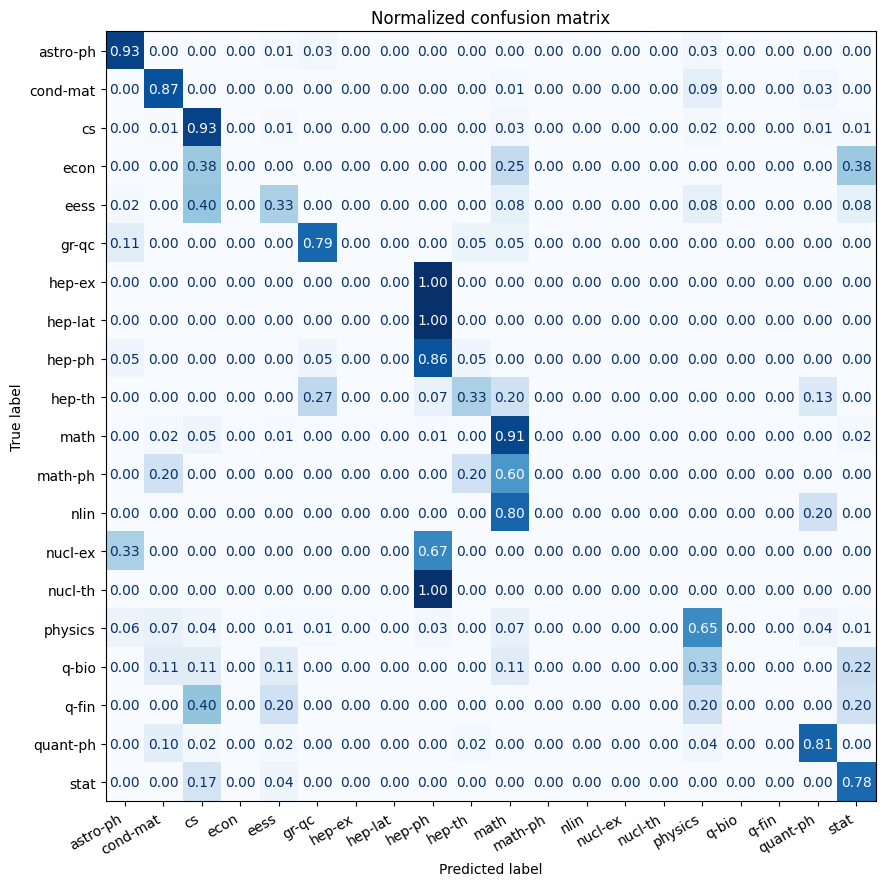

In [20]:
plot_confusion_matrix(y_preds, y_valid, labels)


In [44]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                         reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}


In [45]:
# Convert our dataset back to PyTorch tensors
data_encoded.set_format("torch",
                        columns=["input_ids", "attention_mask", "label"])
# Compute loss values
data_encoded["validation"] = data_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)


Map:   0%|          | 0/890 [00:00<?, ? examples/s]

In [46]:
def label_int2str(row):
    return data["train"].features["label"].int2str(row)


In [47]:
data_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = data_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))


In [54]:
df_test.sort_values("loss", ascending=False).head(10)


,text,label,predicted_label,loss
716,Detecting relevant dependencies under measurem...,stat,astro-ph,6.758710
74,Exact solutions for the moments of the binary ...,nucl-th,math,6.502712
320,Natural Theories\nWe consider the class of phy...,physics,math,6.453927
600,Interacting Copies of Random Constraint Satisf...,cond-mat,math,6.168572
538,Solitons of the constrained Schrödinger equati...,nlin,math,6.033093
759,POMATO: Marrying Pointmap Matching with Tempor...,eess,cs,5.781720
162,Hybrid Random Concentrated Optimization Withou...,physics,cs,5.771364
540,Characterization of the $W_{1+\infty}$-n-algeb...,math-ph,math,5.677855
797,Dynamics of localized states in the stochastic...,nlin,math,5.580626
773,OmniAudio: Generating Spatial Audio from 360-D...,eess,cs,5.515879


In [50]:
df_test.sort_values("loss", ascending=True).head(10)


,text,label,predicted_label,loss
766,ZIP: An Efficient Zeroth-order Prompt Tuning f...,cs,cs,0.009002
787,ERPO: Advancing Safety Alignment via Ex-Ante R...,cs,cs,0.009215
236,Heimdall: test-time scaling on the generative ...,cs,cs,0.009392
492,Efficient Prompt Tuning for Hierarchical Ingre...,cs,cs,0.009413
534,FingER: Content Aware Fine-grained Evaluation ...,cs,cs,0.009451
124,The Future of MLLM Prompting is Adaptive: A Co...,cs,cs,0.009462
264,Taylor Series-Inspired Local Structure Fitting...,cs,cs,0.009463
253,Guiding Reasoning in Small Language Models wit...,cs,cs,0.009463
258,DianJin-R1: Evaluating and Enhancing Financial...,cs,cs,0.009490
302,VAPO: Efficient and Reliable Reinforcement Lea...,cs,cs,0.009511
